In [1]:
import xupy as xp
import matplotlib.pyplot as plt
# from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.woofer_tweeter_ao_class import WooferTweeterAO
from ekarus.e2e.utils.image_utils import reshape_on_mask
from numpy.ma import masked_array

from ekarus.e2e.devices.slope_computer import SlopeComputer
from ekarus.e2e.devices.pyr3_wfs import Pyr3WFS


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
wt = WooferTweeterAO('test_wfs')#'ristretto')
KL,_ = wt.define_KL_modes(wt.dm,zern_modes=2)

Modulating 0 [lambda/D] with 0 modulation steps


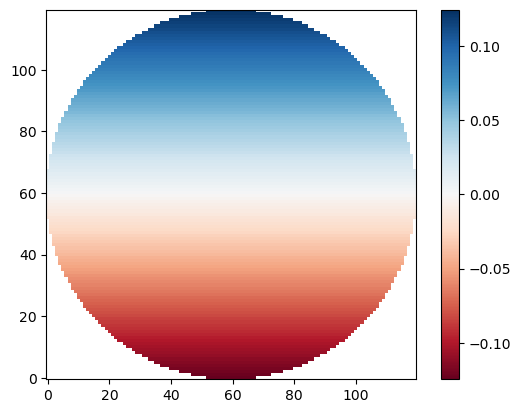

In [3]:
mode_id = 1
mode = KL[mode_id,:]
amp = 1e-8

m2rad = 2*xp.pi/wt.wfs1.lambdaInM
lambdaOverD = wt.wfs1.lambdaInM/wt.pupilSizeInM
nPhotons = None

ef_amp = 1-wt.cmask
in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,wt.cmask),dtype=xp.cfloat)


plt.figure()
plt.imshow(masked_array(xp.asnumpy(xp.angle(in_ef)),xp.asnumpy(wt.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()

Total flux on detector is: 11304 counts
Total flux on zWFS detector is: 11304 counts
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Total flux on 3PWFS detector is: 11304 counts


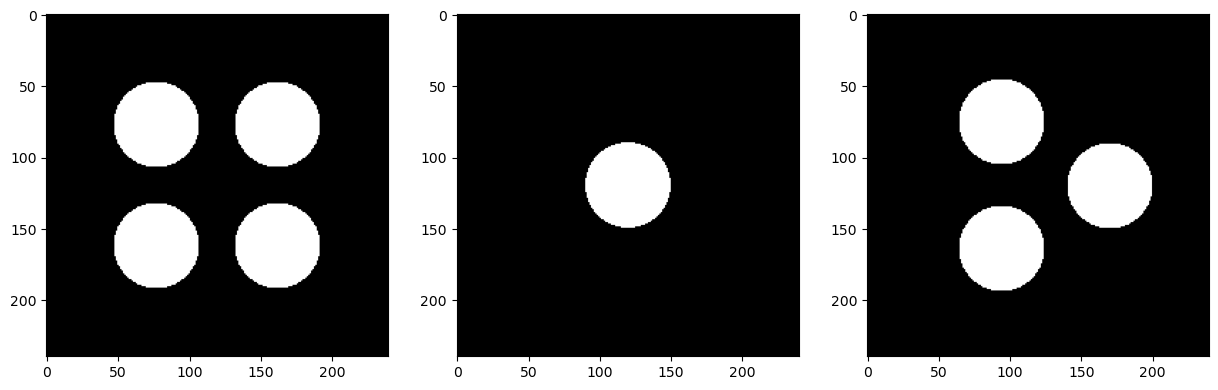

In [4]:
def get_slope(sc,in_ef, lambdaOverD, nPhotons=None):
    intensity = sc._wfs.get_intensity(in_ef, lambdaOverD)
    detector_image = sc._detector.image_on_detector(intensity, photon_flux=nPhotons)
    A = detector_image[~sc._roi_masks[0]]
    B = detector_image[~sc._roi_masks[1]]
    C = detector_image[~sc._roi_masks[2]]
    D = detector_image[~sc._roi_masks[3]]
    up_down = (A+B) - (C+D)
    left_right = (A+C) - (B+D)
    # print(xp.sum(abs(up_down)),xp.sum(abs(left_right)))
    slopes = xp.hstack((up_down, left_right))
    return slopes

def get_delta_slope(in_ef, lambdaOverD, nPhotons=None):
    push_slopes = get_slope(wt.sc1,in_ef,lambdaOverD=lambdaOverD,nPhotons=nPhotons)
    push_frame = wt.ccd1.last_frame.copy()
    pull_slopes = get_slope(wt.sc1,xp.conj(in_ef),lambdaOverD=lambdaOverD,nPhotons=nPhotons)
    pull_frame = wt.ccd1.last_frame.copy()
    slopes = (push_slopes-pull_slopes)/amp/2
    dframe = (push_frame-pull_frame)/2
    return slopes,dframe

zero_phase = ef_amp.astype(xp.cfloat)

slope_null,_ = get_delta_slope(zero_phase,lambdaOverD)
unmod_frame_null = wt.ccd1.last_frame.copy()
flux = xp.sum(unmod_frame_null)
print(f'Total flux on detector is: {flux:1.0f} counts')
pyr_masks = xp.sum(1-wt.sc1._roi_masks,axis=0)

zslope_null = wt.sc2.compute_slopes(zero_phase,lambdaOverD,nPhotons=None)
zframe_null = wt.ccd2.last_frame.copy()
zern_mask = 1-wt.sc2._roi_masks
zflux = xp.sum(zframe_null)
print(f'Total flux on zWFS detector is: {zflux:1.0f} counts')

subapertureSize = 60
subapPixSep = 60
rebin = wt.wfs1.oversampling*wt.pupilSizeInPixels/max(wt.ccd1.detector_shape)
vertex_angle = 2*xp.pi*wt.wfs1.lambdaInM/wt.pupilSizeInM*((xp.floor(subapertureSize+1.0)+subapPixSep)/(2*xp.cos(xp.pi/6)))*rebin/2
pyr3 = Pyr3WFS(vertex_angle=vertex_angle,oversampling=wt.wfs1.oversampling,sensorLambda=wt.wfs1.lambdaInM)
sc3 = SlopeComputer(pyr3,wt.ccd1,{'modulationInLambdaOverD':0.0})
args = {'zero_phase': zero_phase, 'lambdaOverD': lambdaOverD, 'Npix': subapertureSize, 'centerObscurationInPixels': 0.0}
sc3.calibrate_sensor(tn=wt._tn, prefix_str='pyr3_',**args)

pyr3.set_modulation_angle(0.0)
slope3_null = sc3.compute_slopes(zero_phase,lambdaOverD,nPhotons=None)
unmod_frame3_null = wt.ccd1.last_frame.copy()
pyr3_mask = xp.sum(1-sc3._roi_masks,axis=0)
pyr3flux = xp.sum(unmod_frame3_null)
print(f'Total flux on 3PWFS detector is: {pyr3flux:1.0f} counts')

plt.figure(figsize=(15,4.5))
plt.subplot(1,3,1)
plt.imshow(xp.asnumpy(pyr_masks),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(zern_mask),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(xp.asnumpy(pyr3_mask),cmap='gray')

Modulating 0 [lambda/D] with 0 modulation steps


Text(0.5, 1.0, 'Photons inside mask: 45%')

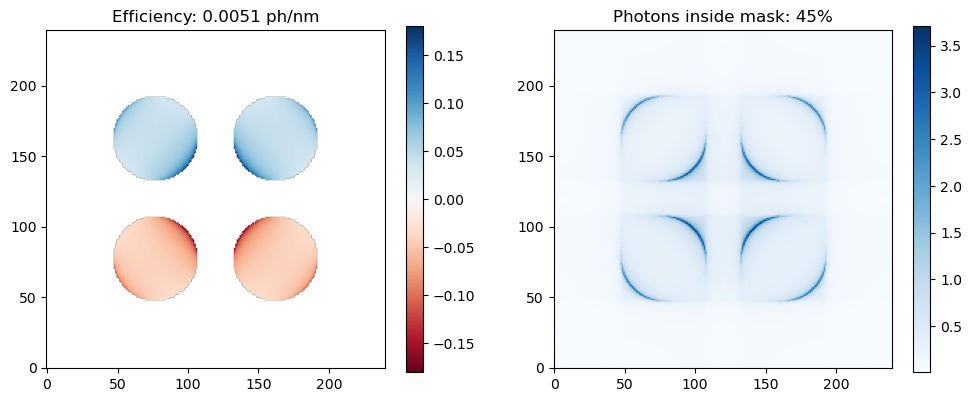

In [5]:
wt.wfs1.set_modulation_angle(0.0)
# Unmodulated case
slopes,dframe = get_delta_slope(in_ef,lambdaOverD)
unmod_img = wt.ccd1.last_frame.copy()

efficiency = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux
nPhotOut = xp.sum(unmod_img[pyr_masks.astype(bool)])
thrp = nPhotOut/flux

plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(dframe),mask=xp.asnumpy(1-pyr_masks)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Efficiency: {efficiency/(amp*1e+9):1.4f} ph/nm')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(unmod_img),origin='lower',cmap='Blues')
plt.colorbar()
plt.title(f'Photons inside mask: {thrp*1e+2:1.0f}%')

Modulating 3 [lambda/D] with 20 modulation steps


Text(0.5, 1.0, 'Photons inside mask: 88%')

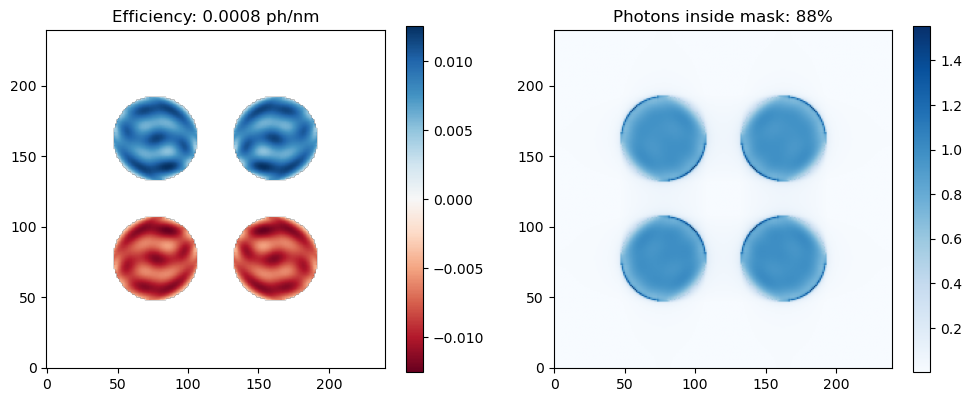

In [6]:
wt.wfs1.set_modulation_angle(3.0)
# Modulated case
slopes,dframe = get_delta_slope(in_ef,lambdaOverD)
unmod_img = wt.ccd1.last_frame.copy()

efficiency = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux
nPhotOut = xp.sum(unmod_img[pyr_masks.astype(bool)])
thrp = nPhotOut/flux

plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(dframe),mask=xp.asnumpy(1-pyr_masks)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Efficiency: {efficiency/(amp*1e+9):1.4f} ph/nm')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(unmod_img),origin='lower',cmap='Blues')
plt.colorbar()
plt.title(f'Photons inside mask: {thrp*1e+2:1.0f}%')

Text(0.5, 1.0, 'Photons inside mask: 53%')

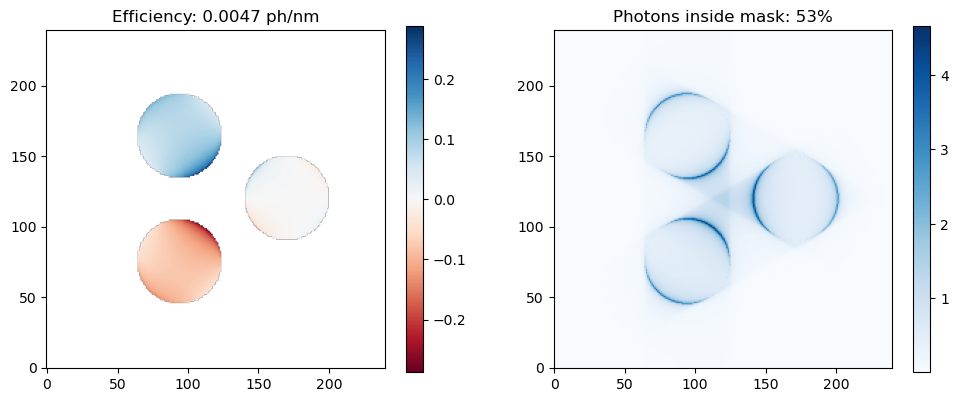

In [7]:
push_signal = sc3.compute_slopes(in_ef,lambdaOverD,nPhotons=None)
push_image = wt.ccd1.last_frame.copy()
pull_signal = sc3.compute_slopes(xp.conj(in_ef),lambdaOverD,nPhotons=None)
pull_image = wt.ccd1.last_frame.copy()

slope = (push_signal-pull_signal)/2
dimage = (push_image-pull_image)/2

efficiency = xp.sum(xp.abs(dimage[pyr3_mask.astype(bool)]))/zflux
nPhotOut = xp.sum(pull_image[pyr3_mask.astype(bool)])
thrp = nPhotOut/zflux

plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(dimage),mask=xp.asnumpy(1-pyr3_mask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Efficiency: {efficiency/(amp*1e+9):1.4f} ph/nm')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(pull_image),origin='lower',cmap='Blues')
plt.colorbar()
plt.title(f'Photons inside mask: {thrp*1e+2:1.0f}%')

Text(0.5, 1.0, 'Photons inside mask: 80%')

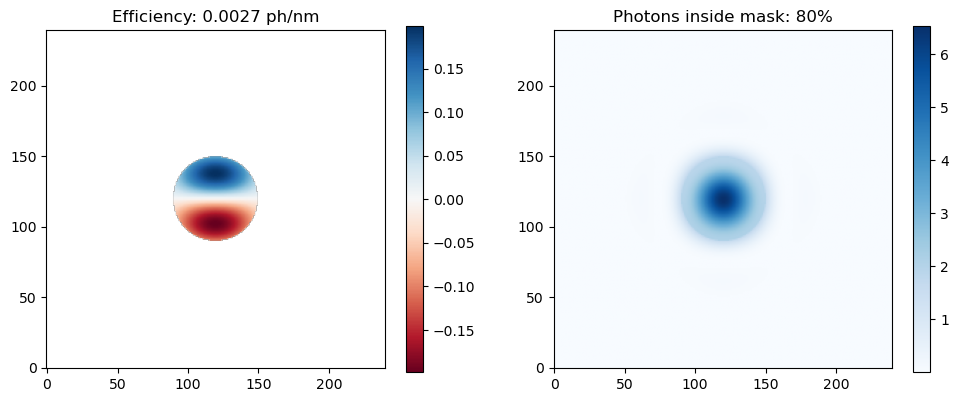

In [8]:
zLambdaOverD = wt.wfs2.lambdaInM/wt.pupilSizeInM

push_signal = wt.sc2.compute_slopes(in_ef,zLambdaOverD,nPhotons=None)
push_zimage = wt.ccd2.last_frame.copy()
pull_signal = wt.sc2.compute_slopes(xp.conj(in_ef),zLambdaOverD,nPhotons=None)
pull_zimage = wt.ccd2.last_frame.copy()

zslope = (push_signal-pull_signal)/2
dzimage = (push_zimage-pull_zimage)/2

efficiency = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux
nPhotOut = xp.sum(pull_zimage[zern_mask.astype(bool)])
thrp = nPhotOut/zflux

plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(dzimage),mask=xp.asnumpy(1-zern_mask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Efficiency: {efficiency/(amp*1e+9):1.4f} ph/nm')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(pull_zimage),origin='lower',cmap='Blues')
plt.colorbar()
plt.title(f'Photons inside mask: {thrp*1e+2:1.0f}%')

In [9]:
# Efficiency vs amplitude, modes 5,50,500
amps = xp.logspace(-9,-5,200)
mode_ids = [6,60,600]

zsens_vs_amp = xp.zeros([len(mode_ids),len(amps)])
z2sens_vs_amp = xp.zeros([len(mode_ids),len(amps)])
pyr3sens_vs_amp = xp.zeros([len(mode_ids),len(amps)])
upyrsens_vs_amp = xp.zeros([len(mode_ids),len(amps)])


for j,mode_id in enumerate(mode_ids):
    mode = KL[mode_id,:]

    for i,amp in enumerate(amps):
        in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,wt.cmask),dtype=xp.cfloat)

        # Unmodulated case
        wt.wfs1.set_modulation_angle(0.0,verbose=False)
        _,dframe = get_delta_slope(in_ef,lambdaOverD)
        upyrsens_vs_amp[j,i] = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux/amp

        # 3PWFS case
        intensity = pyr3.get_intensity(in_ef,lambdaOverD)
        push_3image = wt.ccd1.image_on_detector(intensity,photon_flux=None)
        intensity = pyr3.get_intensity(xp.conj(in_ef),lambdaOverD)
        pull_3image = wt.ccd1.image_on_detector(intensity,photon_flux=None)
        dimage = (push_3image-pull_3image)/2
        pyr3sens_vs_amp[j,i] = xp.sum(xp.abs(dimage[pyr3_mask.astype(bool)]))/pyr3flux/amp

        # ZWFS case
        wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.0)
        intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
        push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
        intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
        pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
        dzimage = (push_zimage-pull_zimage)/2
        zsens_vs_amp[j,i] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux/amp

        # Z2WFS case
        wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=2.0,dotDelayInradians=0.5)
        intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
        push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
        intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
        pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
        dzimage = (push_zimage-pull_zimage)/2
        z2sens_vs_amp[j,i] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux/amp

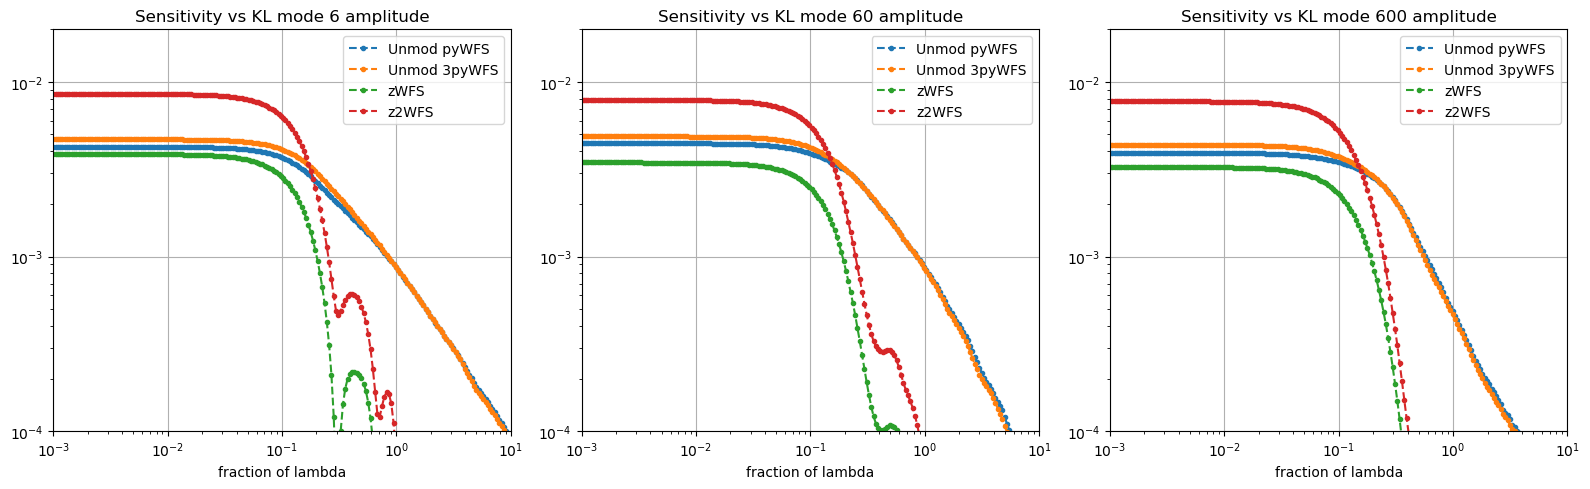

In [10]:
plt.figure(figsize=(16,5))
for i in range(len(mode_ids)):
    plt.subplot(1,len(mode_ids),i+1)
    plt.plot(xp.asnumpy(amps)/wt.wfs1.lambdaInM,xp.asnumpy(upyrsens_vs_amp[i])*1e-9,'--.',label='Unmod pyWFS')
    plt.plot(xp.asnumpy(amps)/wt.wfs1.lambdaInM,xp.asnumpy(pyr3sens_vs_amp[i])*1e-9,'--.',label='Unmod 3pyWFS')
    plt.plot(xp.asnumpy(amps)/wt.wfs1.lambdaInM,xp.asnumpy(zsens_vs_amp[i])*1e-9,'--.',label='zWFS')
    plt.plot(xp.asnumpy(amps)/wt.wfs1.lambdaInM,xp.asnumpy(z2sens_vs_amp[i])*1e-9,'--.',label='z2WFS')
    plt.grid()
    plt.legend()
    plt.title(f'Sensitivity vs KL mode {mode_ids[i]:1.0f} amplitude')
    plt.xlabel('fraction of lambda')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1e-4,2e-2])
    plt.xlim([1e-3,10])
plt.tight_layout()

In [11]:
# Efficiency vs mode, small amplitude
Nmax = 1000

rMods = xp.array([0.0,0.5,2.0,3.0,4.0,6.0])

zsens = xp.zeros(Nmax)
z2sens = xp.zeros(Nmax)
pyrsens = xp.zeros([len(rMods),Nmax])
pyr3sens = xp.zeros(Nmax)

zsens_shot = xp.zeros(Nmax)
z2sens_shot = xp.zeros(Nmax)
pyrsens_shot = xp.zeros([len(rMods),Nmax])
pyr3sens_shot = xp.zeros(Nmax)

amp = 1e-8
pyr_thrp = xp.zeros(len(rMods))

for k,rMod in enumerate(rMods):
    wt.wfs1.set_modulation_angle(rMod,verbose=False)
    wt.sc1.compute_slopes(zero_phase,lambdaOverD,nPhotons=None)
    mod_frame_null = wt.ccd1.last_frame.copy()
    pyr_thrp[k] = xp.sum(mod_frame_null[pyr_masks.astype(bool)])/xp.sum(mod_frame_null)

# Throughput
upyr3_thrp = xp.sum(unmod_frame3_null[pyr3_mask.astype(bool)])/xp.sum(unmod_frame3_null)
zern_thrp = xp.sum(zframe_null[zern_mask.astype(bool)])/xp.sum(zframe_null)

for mode_id in range(Nmax):
    print(f'\rMode {mode_id+1}/{Nmax}', end='\r', flush=True)
    mode = KL[mode_id,:]
    in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,wt.cmask),dtype=xp.cfloat)

    # Unmodulated case
    for k,rMod in enumerate(rMods):
        wt.wfs1.set_modulation_angle(rMod,verbose=False)
        _,dframe = get_delta_slope(in_ef,lambdaOverD)
        pyrsens[k,mode_id] = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux
        pyrsens_shot[k,mode_id] = xp.sum(xp.abs(dframe)[pyr_masks.astype(bool)]/unmod_frame_null[pyr_masks.astype(bool)])/pyr_thrp[k]

    # 3PWFS case
    intensity = pyr3.get_intensity(in_ef,lambdaOverD)
    push_3image = wt.ccd1.image_on_detector(intensity,photon_flux=None)
    intensity = pyr3.get_intensity(xp.conj(in_ef),lambdaOverD)
    pull_3image = wt.ccd1.image_on_detector(intensity,photon_flux=None)
    dimage = (push_3image-pull_3image)/2
    pyr3sens[mode_id] = xp.sum(xp.abs(dimage[pyr3_mask.astype(bool)]))/pyr3flux
    pyr3sens_shot[mode_id] = xp.sum(xp.abs(dimage)[pyr3_mask.astype(bool)]/unmod_frame3_null[pyr3_mask.astype(bool)])/upyr3_thrp

    # ZWFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.0)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    zsens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux
    zsens_shot[mode_id] = xp.sum(xp.abs(dzimage)[zern_mask.astype(bool)]/zframe_null[zern_mask.astype(bool)])/zern_thrp

    # Z2WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=2.0)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z2sens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux
    z2sens_shot[mode_id] = xp.sum(xp.abs(dzimage)[zern_mask.astype(bool)]/zframe_null[zern_mask.astype(bool)])/zern_thrp

upyrsens = pyrsens[0].copy()
upyrsens_shot = pyrsens_shot[0].copy()

In [12]:
# print(upyr_thrp,upyr3_thrp,zern_thrp,mpyr_thrp)

Text(0.5, 1.0, 'RON sensitivity\n(60x60 subapertures, $\\lambda$=1000nm)')

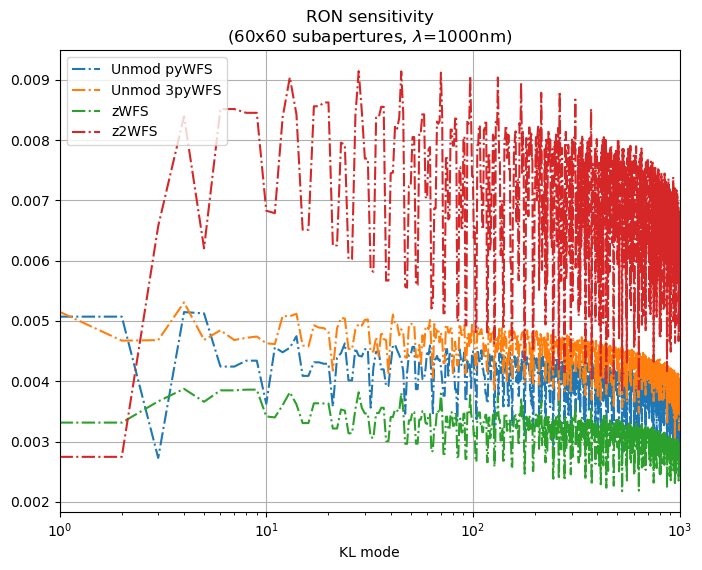

In [13]:
x = xp.asnumpy(xp.arange(Nmax)+1)

plt.figure(figsize=(8,6))
plt.plot(x,xp.asnumpy(upyrsens/(amp*1e+9)),'-.',label='Unmod pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
plt.plot(x,xp.asnumpy(pyr3sens/(amp*1e+9)),'-.',label='Unmod 3pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
# plt.plot(x,xp.asnumpy(pyrsens/(amp*1e+9)),'-.',label=f'{rMod:1.0f} '+r'$\lambda/D$ pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
plt.plot(x,xp.asnumpy(zsens/(amp*1e+9)),'-.',label=f'zWFS')#+f' ({wt.wfs2.lambdaInM*1e+9:1.0f}nm)')# ({wt.wfs2.dot_radius:1.0f}'+r'$\lambda/D$, $\pi/2$)')
plt.plot(x,xp.asnumpy(z2sens/(amp*1e+9)),'-.',label=f'z2WFS')#+f' ({wt.wfs2.lambdaInM*1e+9:1.0f}nm)')# ({wt.wfs2.dot_radius:1.0f}'+r'$\lambda/D$, $\pi/2$)')
plt.grid()
plt.legend()
plt.xscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
# plt.ylabel('[ph/nm]')
plt.title(f'RON sensitivity\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')

In [14]:
# plt.figure()
# plt.plot((pyr3sens/upyrsens).get(),'-.')
# plt.grid()
# plt.xscale('log')

Text(0.5, 1.0, 'Sensitivity (RON)\n(60x60 subapertures, $\\lambda$=1000nm)')

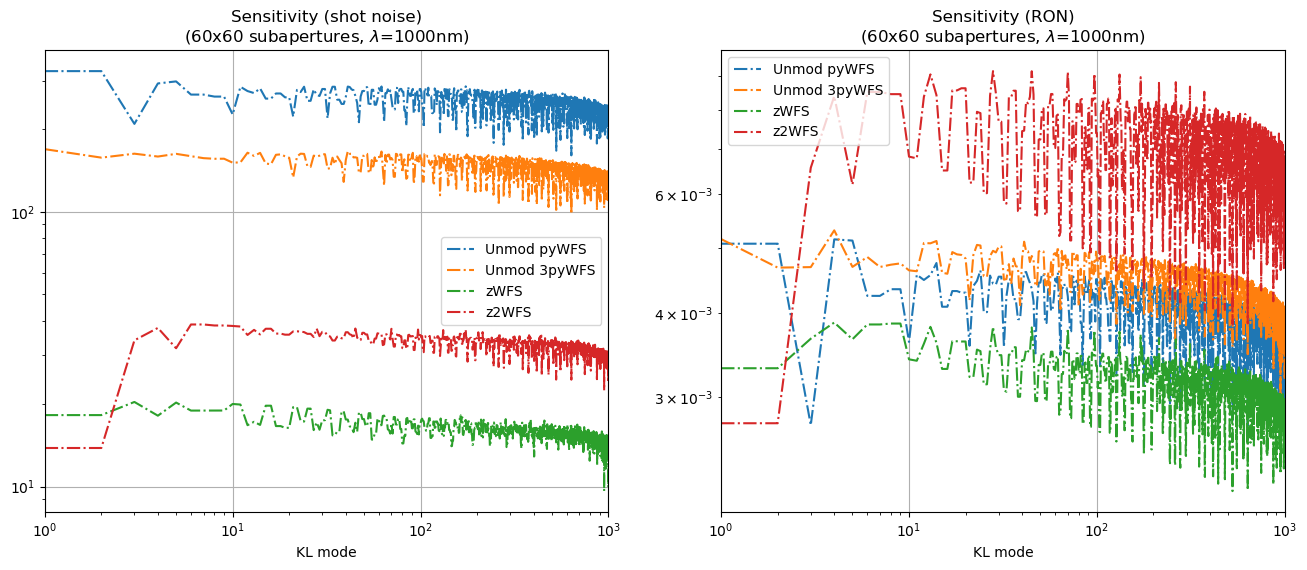

In [15]:
x = xp.asnumpy(xp.arange(Nmax)+1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(x,xp.asnumpy(upyrsens_shot/(amp*1e+9)),'-.',label='Unmod pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
plt.plot(x,xp.asnumpy(pyr3sens_shot/(amp*1e+9)),'-.',label='Unmod 3pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
# plt.plot(x,xp.asnumpy(pyrsens_shot/(amp*1e+9)),'-.',label=r'3.0 $\lambda/D$ pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
plt.plot(x,xp.asnumpy(zsens_shot/(amp*1e+9)),'-.',label=f'zWFS')#+f' ({wt.wfs2.lambdaInM*1e+9:1.0f}nm)')# ({wt.wfs2.dot_radius:1.0f}'+r'$\lambda/D$, $\pi/2$)')
plt.plot(x,xp.asnumpy(z2sens_shot/(amp*1e+9)),'-.',label=f'z2WFS')#+f' ({wt.wfs2.lambdaInM*1e+9:1.0f}nm)')# ({wt.wfs2.dot_radius:1.0f}'+r'$\lambda/D$, $\pi/2$)')
plt.grid()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
# plt.ylabel('[ph/nm]')
plt.title(f'Sensitivity (shot noise)\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')
plt.subplot(1,2,2)
plt.plot(x,xp.asnumpy(upyrsens/(amp*1e+9)),'-.',label='Unmod pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
plt.plot(x,xp.asnumpy(pyr3sens/(amp*1e+9)),'-.',label='Unmod 3pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
# plt.plot(x,xp.asnumpy(pyrsens/(amp*1e+9)),'-.',label=f'{rMod:1.0f} '+r'$\lambda/D$ pyWFS')#+f' ({wt.wfs1.lambdaInM*1e+9:1.0f}nm)')
plt.plot(x,xp.asnumpy(zsens/(amp*1e+9)),'-.',label=f'zWFS')#+f' ({wt.wfs2.lambdaInM*1e+9:1.0f}nm)')# ({wt.wfs2.dot_radius:1.0f}'+r'$\lambda/D$, $\pi/2$)')
plt.plot(x,xp.asnumpy(z2sens/(amp*1e+9)),'-.',label=f'z2WFS')#+f' ({wt.wfs2.lambdaInM*1e+9:1.0f}nm)')# ({wt.wfs2.dot_radius:1.0f}'+r'$\lambda/D$, $\pi/2$)')
plt.grid()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
# plt.ylabel('[ph/nm]')
plt.title(f'Sensitivity (RON)\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')

Text(0.5, 1.0, 'Sensitivity (RON)\n(60x60 subapertures, $\\lambda$=1000nm)')

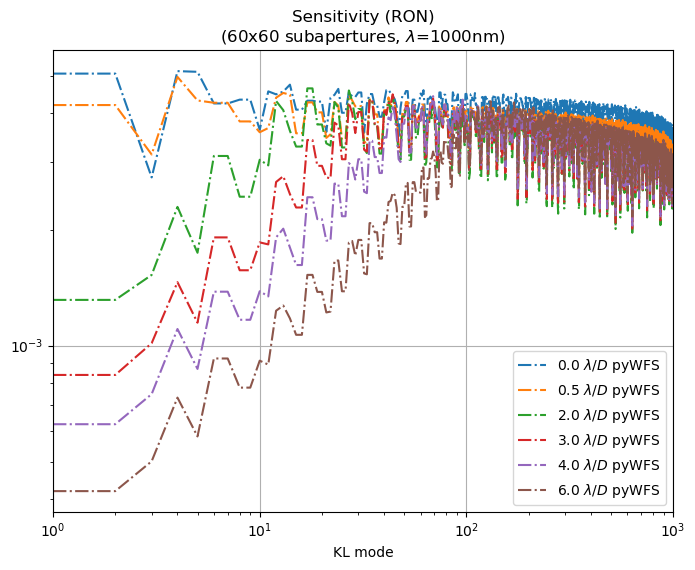

In [16]:
plt.figure(figsize=(8,6))
for k,rMod in enumerate(rMods):
    plt.plot(x,xp.asnumpy(pyrsens[k]/(amp*1e+9)),'-.',label=f'{rMod:1.1f} ' + r'$\lambda/D$ pyWFS')
plt.grid()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
plt.title(f'Sensitivity (RON)\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')

Text(0.5, 1.0, 'Sensitivity (RON)\n(60x60 subapertures, $\\lambda$=1000nm)')

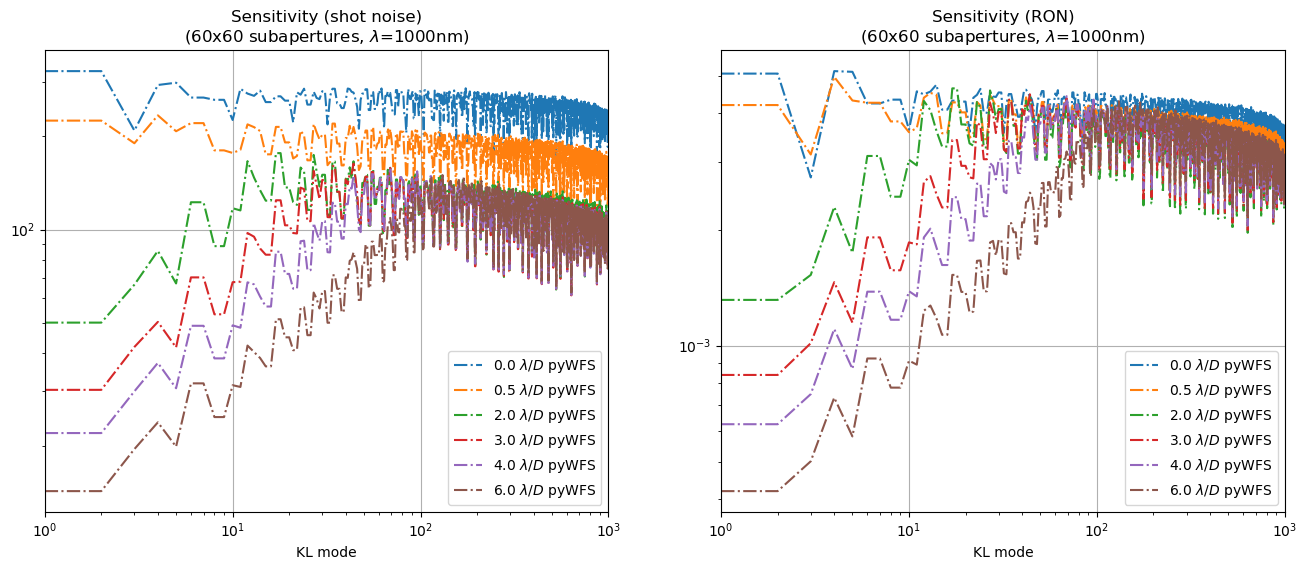

In [17]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for k,rMod in enumerate(rMods):
    plt.plot(x,xp.asnumpy(pyrsens_shot[k]/(amp*1e+9)),'-.',label=f'{rMod:1.1f} ' + r'$\lambda/D$ pyWFS')
plt.grid()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
plt.title(f'Sensitivity (shot noise)\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')
plt.subplot(1,2,2)
for k,rMod in enumerate(rMods):
    plt.plot(x,xp.asnumpy(pyrsens[k]/(amp*1e+9)),'-.',label=f'{rMod:1.1f} ' + r'$\lambda/D$ pyWFS')
plt.grid()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
plt.title(f'Sensitivity (RON)\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')

In [18]:
Nmax = 100

zsens4 = xp.zeros(Nmax)
zsens4 = xp.zeros(Nmax)
z2sens4 = xp.zeros(Nmax)
zsens6 = xp.zeros(Nmax)
z2sens6 = xp.zeros(Nmax)
zsens8 = xp.zeros(Nmax)
z2sens8 = xp.zeros(Nmax)

amp = 1e-8

for mode_id in range(Nmax):
    print(f'\rMode {mode_id+1}/{Nmax}', end='\r', flush=True)
    mode = KL[mode_id,:]
    in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,wt.cmask),dtype=xp.cfloat)

    # ZWFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.0,dotDelayInradians=0.25)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    zsens4[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # Z2WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=2.0,dotDelayInradians=0.25)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z2sens4[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # ZWFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.0,dotDelayInradians=0.33)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    zsens6[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # Z2WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=2.0,dotDelayInradians=0.33)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z2sens6[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux


    # ZWFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.0,dotDelayInradians=0.125)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    zsens8[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # Z2WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=2.0,dotDelayInradians=0.125)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z2sens8[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

Text(0.5, 1.0, 'RON sensitivity\n(60x60 subapertures, $\\lambda$=1000nm)')

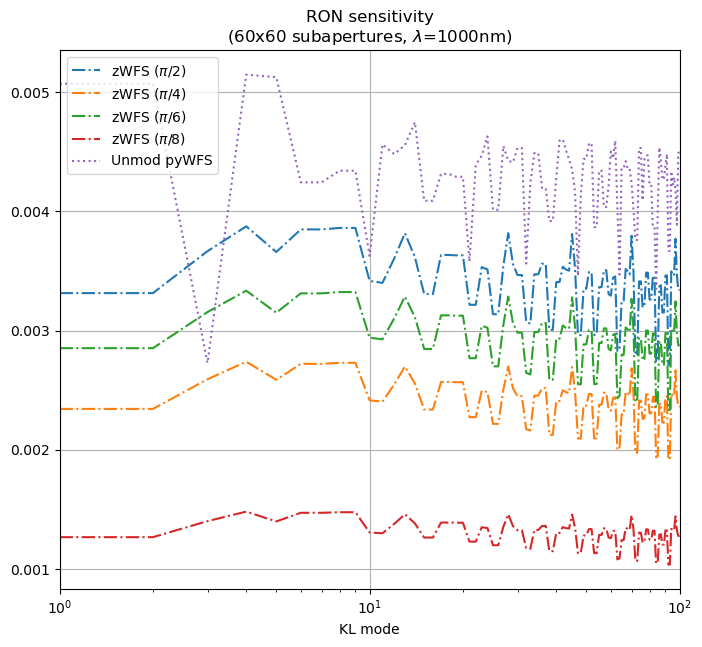

In [19]:
x = xp.asnumpy(xp.arange(Nmax)+1)

plt.figure(figsize=(8,7))
plt.plot(x,xp.asnumpy(zsens[:Nmax]/(amp*1e+9)),'-.',label=f'zWFS '+r'($\pi/2$)')
plt.plot(x,xp.asnumpy(zsens4/(amp*1e+9)),'-.',label=f'zWFS '+r'($\pi/4$)')
plt.plot(x,xp.asnumpy(zsens6/(amp*1e+9)),'-.',label=f'zWFS '+r'($\pi/6$)')
plt.plot(x,xp.asnumpy(zsens8/(amp*1e+9)),'-.',label=f'zWFS '+r'($\pi/8$)')
# plt.plot(x,xp.asnumpy(z2sens[:Nmax]/(amp*1e+9)),':',label=f'z2WFS '+r'($\pi/2$)')
plt.plot(x,xp.asnumpy(upyrsens[:Nmax]/(amp*1e+9)),':',label=f'Unmod pyWFS')
plt.grid()
plt.legend()
plt.xscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
# plt.ylabel('[ph/nm]')
plt.title(f'RON sensitivity\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')

In [20]:
Nmax = 1000

z05sens = xp.zeros(Nmax)
z125sens = xp.zeros(Nmax)
z15sens = xp.zeros(Nmax)
z175sens = xp.zeros(Nmax)
z25sens = xp.zeros(Nmax)
z3sens = xp.zeros(Nmax)

amp = 1e-8

for mode_id in range(Nmax):
    print(f'\rMode {mode_id+1}/{Nmax}', end='\r', flush=True)
    mode = KL[mode_id,:]
    in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,wt.cmask),dtype=xp.cfloat)

    # Z05WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=0.5,dotDelayInradians=0.5)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z05sens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # Z125WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.25,dotDelayInradians=0.5)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z125sens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # Z15WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.5,dotDelayInradians=0.5)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z15sens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # Z175WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=1.75,dotDelayInradians=0.5)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z175sens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

    # Z25WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=2.5,dotDelayInradians=0.5)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z25sens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux


    # Z3WFS case
    wt.wfs2.change_dot_parameters(dotSizeInLambdaOverD=3.0,dotDelayInradians=0.5)
    intensity = wt.wfs2.get_intensity(in_ef,zLambdaOverD)
    push_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    intensity = wt.wfs2.get_intensity(xp.conj(in_ef),zLambdaOverD)
    pull_zimage = wt.ccd2.image_on_detector(intensity,photon_flux=None)
    dzimage = (push_zimage-pull_zimage)/2
    z3sens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux

Text(0.5, 1.0, 'RON sensitivity\n(60x60 subapertures, $\\lambda$=1000nm)')

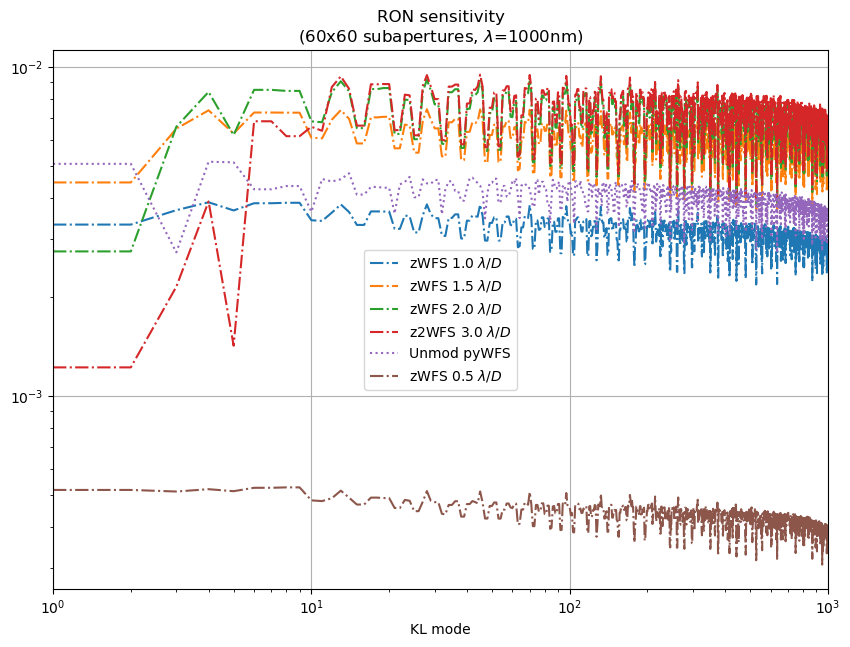

In [21]:
x = xp.asnumpy(xp.arange(Nmax)+1)

plt.figure(figsize=(10,7))
plt.plot(x,xp.asnumpy(zsens/(amp*1e+9)),'-.',label=f'zWFS '+r'1.0 $\lambda/D$')
# plt.plot(x,xp.asnumpy(z125sens/(amp*1e+9)),'-.',label=f'zWFS '+r'1.25 $\lambda/D$')
plt.plot(x,xp.asnumpy(z15sens/(amp*1e+9)),'-.',label=f'zWFS '+r'1.5 $\lambda/D$')
# plt.plot(x,xp.asnumpy(z175sens/(amp*1e+9)),'-.',label=f'zWFS '+r'1.75 $\lambda/D$')
plt.plot(x,xp.asnumpy(z2sens/(amp*1e+9)),'-.',label=f'zWFS '+r'2.0 $\lambda/D$')
plt.plot(x,xp.asnumpy(z3sens/(amp*1e+9)),'-.',label=f'z2WFS '+r'3.0 $\lambda/D$')
plt.plot(x,xp.asnumpy(upyrsens[:Nmax]/(amp*1e+9)),':',label=f'Unmod pyWFS')
plt.plot(x,xp.asnumpy(z05sens/(amp*1e+9)),'-.',label=f'zWFS '+r'0.5 $\lambda/D$')
plt.grid()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('KL mode')
plt.xlim([1,Nmax])
# plt.ylabel('[ph/nm]')
plt.title(f'RON sensitivity\n(60x60 subapertures, '+r'$\lambda$='+f'{wt.wfs2.lambdaInM*1e+9:1.0f}nm)')